In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

import itertools
import os
import re
from collections import namedtuple
from pathlib import Path

_PRNG = RandomState(0)

In [2]:
_DATA_DIR = "./data"
_FILE_PROCESSED_DATASET = "lendingclub_2016-2018_processed.csv"
_FILE_PATH_PROCESSED_DATASET = Path(_DATA_DIR + "/" + _FILE_PROCESSED_DATASET)

_IS_PROCESSED_DATASET = False

df = None
# Read in the data, check if a preprocessed dataset exists
if _FILE_PATH_PROCESSED_DATASET.is_file():
    print("Preprocessed dataset found, reading preprocessed dataset")
    _IS_PROCESSED_DATASET = True
    df = pd.read_csv(_FILE_PATH_PROCESSED_DATASET)
else:
    # Read all data
    print("Preprocessed dataset not found, reading all data")
    _dataset_loan_columns = ["loan_amnt",
                             "int_rate",
                             "term",
                             "grade",
                             "sub_grade",
                             "installment",
                             "annual_inc",
                             "loan_status",
                             "verification_status",
                             "purpose"]

    dataset_loans = {}
    for file_name in os.listdir(_DATA_DIR):
        if file_name.endswith(".csv"):
            full_file_path = _DATA_DIR + "/" + file_name
            print(full_file_path)
            loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
            dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]
    
    # Combine all the data into a single dataframe
    print("Combining all the data into a single dataframe")
    for k, dataset in dataset_loans.items():
        if df is None:
            df = dataset
            continue
        df = df.append(dataset, ignore_index=True)

    del dataset_loans
        
    # Convert column types
    print("Converting column types")
    df["loan_amnt"] = df["loan_amnt"].astype(int)
    df["annual_inc"] = df["annual_inc"].astype(int)
    df["int_rate"] = df["int_rate"].apply(lambda int_rate: float(int_rate[:-1]))
    df["term"] = df["term"].apply(lambda term: int(re.search(r'\d+', term).group(0)))
    
    # Remove outliers
    # Annual income must be greater than 0 and less than 1 million
    # Assume 0 is an outlier
    # Assume millioniare+ are outliers
    print("Removing outliers")
    df = df.loc[(df["annual_inc"] > 0) & (df["annual_inc"] < 1000000)]
    
    # Convert non-ordinal categorical variables to binary vectors
    print("Convert non-ordinal categorical variables to binary vectors (this can take a while)")
    total_columns_to_process = len(df["verification_status"].unique()) + len(df["purpose"].unique())
    columns_processed = 0
    for verification_status in df["verification_status"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", verification_status)
        df["vs_" + verification_status] = df.apply(lambda row: int(row["verification_status"] == verification_status), axis=1)
    for purpose in df["purpose"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", purpose)
        df["p_" + purpose] = df.apply(lambda row: int(row["purpose"] == purpose), axis=1)

    df.drop(columns=["verification_status"], inplace=True)
    df.drop(columns=["purpose"], inplace=True)
    
    # Save processed dataset for future use
    print("Saving processed dataset")
    df.to_csv(_FILE_PATH_PROCESSED_DATASET, index=False, header=True)
    
    print("Done!")

Preprocessed dataset not found, reading all data
./data/LoanStats_2016Q1.csv
./data/LoanStats_2016Q2.csv
./data/LoanStats_2016Q3.csv
./data/LoanStats_2016Q4.csv
./data/LoanStats_2017Q1.csv
./data/LoanStats_2017Q2.csv
./data/LoanStats_2017Q3.csv
./data/LoanStats_2017Q4.csv
./data/LoanStats_2018Q1.csv
./data/LoanStats_2018Q2.csv
./data/LoanStats_2018Q3.csv
./data/LoanStats_2018Q4.csv
Combining all the data into a single dataframe
Converting column types
Removing outliers
Convert non-ordinal categorical variables to binary vectors (this can take a while)
[1/17] Source Verified
[2/17] Verified
[3/17] Not Verified
[4/17] credit_card
[5/17] debt_consolidation
[6/17] small_business
[7/17] home_improvement
[8/17] other
[9/17] major_purchase
[10/17] vacation
[11/17] moving
[12/17] medical
[13/17] car
[14/17] house
[15/17] renewable_energy
[16/17] wedding
[17/17] educational
Saving processed dataset
Done!


In [3]:
print("Number of loans in combined dataset:", len(df))
df.head(5)

Number of loans in combined dataset: 1371066


,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,5000,17.27,36,D,D2,178.94,62000,Fully Paid,1,0,...,0,0,0,0,0,0,0,0,0,0
1,22000,6.49,36,A,A2,674.18,134000,Current,0,1,...,0,0,0,0,0,0,0,0,0,0
2,30000,10.75,60,B,B4,648.54,125000,Fully Paid,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10000,16.29,36,D,D1,353.01,40000,Charged Off,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12000,9.75,36,B,B3,385.80,120000,Current,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check if we have any null values
df[df.isnull().any(axis=1)]

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational


### Preprocessing

In [5]:
# Convert ordinal categorical variables to numerical
from sklearn.preprocessing import LabelEncoder  

le_grade = LabelEncoder()
df["grade"] = le_grade.fit_transform(df["grade"])

le_sub_grade = LabelEncoder()
df["sub_grade"] = le_sub_grade.fit_transform(df["sub_grade"])

In [6]:
df_pos = df.loc[df["loan_status"] == "Fully Paid"]
df_neg = df.loc[(df["loan_status"] == "Default") | (df["loan_status"] == "Charged Off")]

In [7]:
df_pos["loan_status"].value_counts()

Fully Paid    382014
Name: loan_status, dtype: int64

In [8]:
df_neg["loan_status"].value_counts()

Charged Off    108758
Default            35
Name: loan_status, dtype: int64

In [9]:
df_pos[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.117732,0.353937,0.114210,0.116027,0.958982,0.422926
int_rate,0.117732,1.000000,0.368597,0.962965,0.987197,0.155487,-0.099715
term,0.353937,0.368597,1.000000,0.357490,0.366070,0.136393,0.079493
grade,0.114210,0.962965,0.357490,1.000000,0.971276,0.148621,-0.099893
sub_grade,0.116027,0.987197,0.366070,0.971276,1.000000,0.151058,-0.108120
installment,0.958982,0.155487,0.136393,0.148621,0.151058,1.000000,0.403238
annual_inc,0.422926,-0.099715,0.079493,-0.099893,-0.108120,0.403238,1.000000


In [10]:
df_neg[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.191178,0.387081,0.187644,0.193173,0.945589,0.450970
int_rate,0.191178,1.000000,0.376418,0.962659,0.983896,0.248679,-0.066134
term,0.387081,0.376418,1.000000,0.372196,0.383811,0.142168,0.109504
grade,0.187644,0.962659,0.372196,1.000000,0.975763,0.238671,-0.068205
sub_grade,0.193173,0.983896,0.383811,0.975763,1.000000,0.244191,-0.070253
installment,0.945589,0.248679,0.142168,0.238671,0.244191,1.000000,0.419332
annual_inc,0.450970,-0.066134,0.109504,-0.068205,-0.070253,0.419332,1.000000


In [11]:
# Take a random subsample, computation constraint, SVMs have poor scalability
SUBSAMPLE_AMOUNT = 100000

df_pos = df_pos.sample(n=SUBSAMPLE_AMOUNT, replace=False, random_state=_PRNG)
df_neg = df_neg.sample(n=SUBSAMPLE_AMOUNT, replace=False, random_state=_PRNG)

df_pos.drop(columns=["loan_status"], inplace=True)
df_neg.drop(columns=["loan_status"], inplace=True)
print("Subsample pos:", len(df_pos))
print("Subsample neg:", len(df_neg))

Subsample pos: 100000
Subsample neg: 100000


In [12]:
# Combine subsamples
df_subsample_X = pd.concat([df_pos, df_neg], ignore_index=True, copy=True)
df_subsample_X = df_subsample_X.astype(float)
df_subsample_Y = [1] * len(df_pos) + [0] * len(df_neg)

assert len(df_subsample_X) == len(df_subsample_Y), "Dataset and labels must be the same size"

In [13]:
# Most libraries recommend a hard normalization, mapping the min and max values of a given dimension to [0,1]
# However, a soft normalization is also feasible using StandardScaler
# https://neerajkumar.org/writings/svm/
# https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [14]:
# Create 80/20 train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.9, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 20000
Training label size: 20000
Test set size: 180000
Test label size: 180000


### Linear SVM

In [15]:
# Use cross-validation to find the best C, using F1-score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Result_C = namedtuple("Result_C", ["C", "score_mean", "scores"])

POSSIBLE_C = [2 ** power for power in range(-5, 9)]

cross_val_results = []
for test_C in POSSIBLE_C:
    svm = SVC(C=test_C, kernel="linear", cache_size=4000, max_iter=-1, random_state=_PRNG)
    cv_scores = cross_val_score(svm, X_train, Y_train, cv=5, scoring='f1', n_jobs=-1)
    cross_val_results.append(Result_C(test_C, cv_scores.mean(), cv_scores))
    print(cross_val_results[-1])

Result_C(C=0.03125, score_mean=0.6496255631308664, scores=array([0.64563567, 0.64958482, 0.64936313, 0.65119583, 0.65234836]))
Result_C(C=0.0625, score_mean=0.6493064613540078, scores=array([0.64360687, 0.64818356, 0.65055582, 0.65094115, 0.65324491]))
Result_C(C=0.125, score_mean=0.6477724880372138, scores=array([0.64454064, 0.64668922, 0.64634146, 0.64932563, 0.65196548]))
Result_C(C=0.25, score_mean=0.6458350556221923, scores=array([0.64415837, 0.64490989, 0.64269774, 0.65110625, 0.64630303]))
Result_C(C=0.5, score_mean=0.6409565770696695, scores=array([0.63708087, 0.64055186, 0.64121756, 0.64597191, 0.63996068]))
Result_C(C=1, score_mean=0.6383949886899085, scores=array([0.63409771, 0.63681592, 0.63874874, 0.64259029, 0.63972229]))
Result_C(C=2, score_mean=0.6354389740710239, scores=array([0.63218971, 0.63374279, 0.63793983, 0.63923733, 0.63408521]))
Result_C(C=4, score_mean=0.6330561868565618, scores=array([0.63141918, 0.62740142, 0.63759938, 0.63556116, 0.6332998 ]))
Result_C(C=8

In [16]:
best_cv = max(cross_val_results, key=lambda x: x.score_mean)
best_cv

Result_C(C=0.03125, score_mean=0.6496255631308664, scores=array([0.64563567, 0.64958482, 0.64936313, 0.65119583, 0.65234836]))

In [17]:
# Use the best C found from cross-validation
svm = SVC(C=best_cv.C, kernel="linear", cache_size=4000, max_iter=-1, verbose=False, random_state=_PRNG)
svm.fit(X_train, Y_train)

SVC(C=0.03125, cache_size=4000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False,
  random_state=<mtrand.RandomState object at 0x0000026B3AC3AFC0>,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
print("We want to see '0' here...:", svm.fit_status_)

We want to see '0' here...: 0


In [19]:
svm.score(X_test, Y_test)

0.6340277777777777

In [20]:
svm.coef_

array([[-0.15787647, -0.71333138, -0.42973528, -1.23711232, -1.32274006,
        -0.17019582,  1.13605292, -0.01249663, -0.21354752,  0.22604415,
         0.04265233,  0.05700592, -0.26032316,  0.11510147, -0.01690068,
         0.13963938, -0.04025979,  0.        , -0.21875   ,  0.23157858,
         0.01275595, -0.0625    ,  0.        ,  0.        ]])

In [21]:
df_pos.columns

Index(['loan_amnt', 'int_rate', 'term', 'grade', 'sub_grade', 'installment',
       'annual_inc', 'vs_Source Verified', 'vs_Verified', 'vs_Not Verified',
       'p_credit_card', 'p_debt_consolidation', 'p_small_business',
       'p_home_improvement', 'p_other', 'p_major_purchase', 'p_vacation',
       'p_moving', 'p_medical', 'p_car', 'p_house', 'p_renewable_energy',
       'p_wedding', 'p_educational'],
      dtype='object')

In [22]:
for col_name, value in zip(df_pos.columns, svm.coef_.ravel()):
    print("{:26s} : {:.4f}".format(col_name, value))

loan_amnt                  : -0.1579
int_rate                   : -0.7133
term                       : -0.4297
grade                      : -1.2371
sub_grade                  : -1.3227
installment                : -0.1702
annual_inc                 : 1.1361
vs_Source Verified         : -0.0125
vs_Verified                : -0.2135
vs_Not Verified            : 0.2260
p_credit_card              : 0.0427
p_debt_consolidation       : 0.0570
p_small_business           : -0.2603
p_home_improvement         : 0.1151
p_other                    : -0.0169
p_major_purchase           : 0.1396
p_vacation                 : -0.0403
p_moving                   : 0.0000
p_medical                  : -0.2188
p_car                      : 0.2316
p_house                    : 0.0128
p_renewable_energy         : -0.0625
p_wedding                  : 0.0000
p_educational              : 0.0000


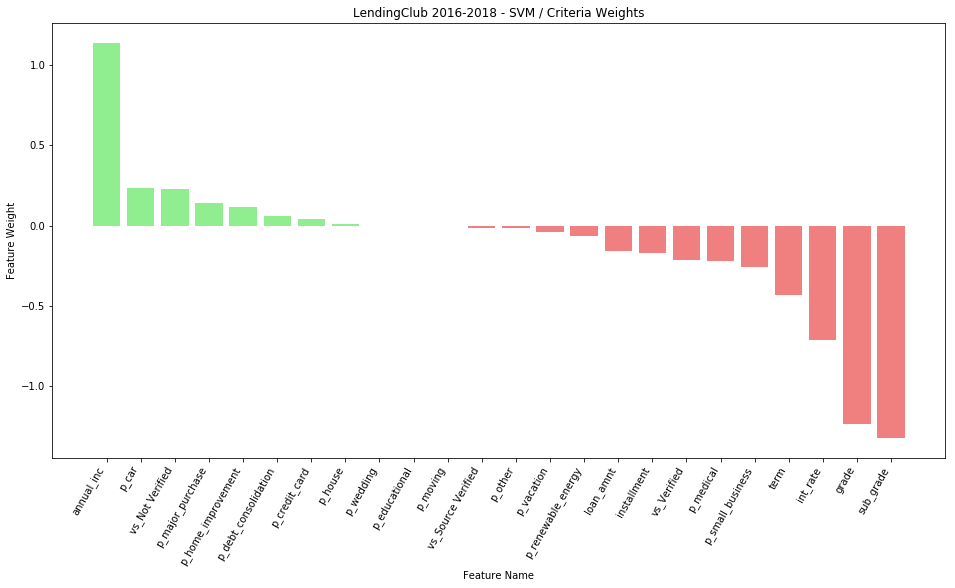

In [23]:
# Plot SVM feature weights
coef = svm.coef_.ravel()
coef_sorted = np.argsort(coef)[::-1]

col = list(df_pos.columns)
colors = ["lightcoral" if feature_weight < 0 else "lightgreen" for feature_weight in coef[coef_sorted]]

plt.figure(figsize=(16, 8))
plt.bar(list(range(len(coef))), coef[coef_sorted], color=colors)
plt.xticks(np.arange(0, len(coef)), [col[idx] for idx in coef_sorted], rotation=60, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Weight")
plt.title("LendingClub 2016-2018 - SVM / Criteria Weights")
# plt.savefig("feature_weights.png", bbox_inches='tight')
plt.show()